# knn解法注释

## 一、把需要的库导入，设置图片外观

In [111]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import * #有星号，以后就可以不写模块的名称了
from datetime import datetime
import matplotlib.pyplot as plt

#外观设置
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.style.use('ggplot')#可以作出ggplot风格的图片



## 二、导入数据，检查数据

In [112]:
#先看看数据长什么样
#因为这张大表非常长，采取这种方法让所有列全部显示
with pd.option_context('display.max_rows', 2, 'display.max_columns', 100):
    print(train)

                air_store_id  visit_date  visitors  dow  year  month  \
0       air_ba937bf13d40fb24  2016-01-13        25    2  2016      1   
...                      ...         ...       ...  ...   ...    ...   
226897  air_b8d9e1624baaadc2  2016-12-04        16    6  2016     12   

        day_of_week  holiday_flg  min_visitors  mean_visitors  \
0                 6            0           7.0      23.843750   
...             ...          ...           ...            ...   
226897            3            0           2.0      10.333333   

        median_visitors  max_visitors  count_observations  air_genre_name  \
0                  25.0          57.0                64.0             4.0   
...                 ...           ...                 ...             ...   
226897              8.0          36.0                36.0             7.0   

        air_area_name   latitude   longitude  air_genre_name0  air_area_name0  \
0                62.0  35.658068  139.751599              4.

In [113]:
#test的区别只是visitors列是空的
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_00a91d42b08b08d9_2017-04-23,3.598508,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170423,8.326629,4.519803,175.447598,0
1,air_00a91d42b08b08d9_2017-04-24,27.341293,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170424,8.326629,4.519803,175.447598,0
2,air_00a91d42b08b08d9_2017-04-25,27.341293,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170425,8.326629,4.519803,175.447598,0
3,air_00a91d42b08b08d9_2017-04-26,30.577498,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170426,8.326629,4.519803,175.447598,0
4,air_00a91d42b08b08d9_2017-04-27,30.577498,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20170427,8.326629,4.519803,175.447598,0


In [114]:
#为了后面的内容加载快，只处理10%的数据
train = pd.read_csv('../input/train_90%.csv')
train1 = pd.read_csv('../input/train_10%.csv')
trainAll = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
#这是一个list，存储了除了前四列之外的所有列的名称。一共50个。因为这4列不应该是模型输入的数据。
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]

In [115]:
#这是一个list，存储了除了前四列之外的所有列的名称。一共50个。因此这4列不应该是模型输入的数据。
col

['dow',
 'year',
 'month',
 'day_of_week',
 'holiday_flg',
 'min_visitors',
 'mean_visitors',
 'median_visitors',
 'max_visitors',
 'count_observations',
 'air_genre_name',
 'air_area_name',
 'latitude',
 'longitude',
 'air_genre_name0',
 'air_area_name0',
 'air_genre_name1',
 'air_area_name1',
 'air_genre_name2',
 'air_area_name2',
 'air_genre_name3',
 'air_area_name3',
 'air_genre_name4',
 'air_area_name4',
 'air_genre_name5',
 'air_area_name5',
 'air_genre_name6',
 'air_area_name6',
 'air_genre_name7',
 'air_area_name7',
 'air_genre_name8',
 'air_area_name8',
 'air_genre_name9',
 'air_area_name9',
 'rs1_x',
 'rv1_x',
 'rs2_x',
 'rv2_x',
 'rs1_y',
 'rv1_y',
 'rs2_y',
 'rv2_y',
 'total_reserv_sum',
 'total_reserv_mean',
 'total_reserv_dt_diff_mean',
 'date_int',
 'var_max_lat',
 'var_max_long',
 'lon_plus_lat',
 'air_store_id2']

Text(0,0.5,'Frequency')

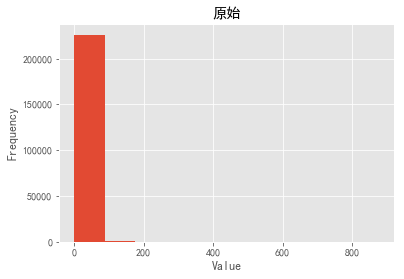

In [116]:
#我们来看看visitor的分布
#显然visitor具有长尾特征。使用log(1 + x)变换比较合适
plt.hist(train['visitors'].values)
plt.title("原始")
plt.xlabel("Value")
plt.ylabel("Frequency")

Text(0,0.5,'Frequency')

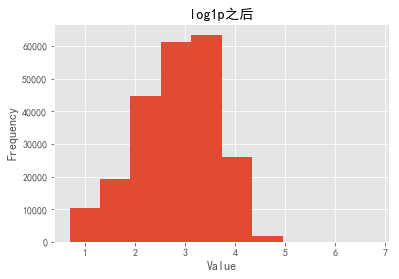

In [117]:
#再看看log1p操作后visitor的分布
plt.hist(np.log1p(train['visitors'].values))
plt.title("log1p之后")
plt.xlabel("Value")
plt.ylabel("Frequency")

## 三、模型验证训练集，调参，计算MSE

In [118]:
#RMSLE方法调用了sk-learn的计算均方误差的方法，返回这个结果的0.5次方。
#MSE定位为各数据偏离真实值的距离平方和的平均数
#传入的参数：y是真实值，pred是估计值
#官方的衡量标准是https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting#evaluation
#与官方的标准是吻合的
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5 

### 1. neighbors = 9    并用了3，4，9，12，15进行验证

In [119]:
model = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=9)
model.fit(train[col], np.log1p(train['visitors'].values))
preds = model.predict(train1[col])
print('RMSE: ', RMSLE(np.log1p(train1['visitors'].values), preds))

RMSE:  0.651317705859885


## 四、预测测试集

In [120]:
model = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=9)
model.fit(trainAll[col], np.log1p(trainAll['visitors'].values))

#给test表中的visitors列赋值 为模型预测的结果
test['visitors'] = model.predict(test[col])
#不过这个值还需要用expm函数把log1p的数变回去
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
#sub就是test只留下id和visitors列
sub = test[['id','visitors']].copy()
#把sub写入csv文件
#这一步运行完，可以在当前目录看到结果生成
sub[['id', 'visitors']].to_csv('submission.csv', index=False)